In [1]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.linalg as la
import scipy.integrate as integrate

from torchdiffeq import odeint, odeint_adjoint
from torchdyn.core import NeuralODE

In [2]:
from utils.graphic_tools import simple_plotter, show_state, visualize_u_from_F, show_err
from utils.analysis_tools import relative_err, rmse, check_weights, downsampling
from utils.models import HeatModel, BurgersModelA
from utils.objectives import mse_fn, ae_fn
from equations.burgers import get_burgers, get_burgers_fd, get_burgers_cons_fd, get_burgers_nicolson, get_burgers_fft
from equations.initial_functions import random_init, high_dim_random_init, burgers_analytical_init
from generators import burgers_snapshot_generator, get_burgers_batch
from training_dataset import generate_burgers_training_dataset, read_dataset, process_dataset

---

# Burgers equation - reconstruction experiments

--- 
##  Training

Let's make a set of initial conditions which will be used for references, training, validation and test

### Initial conditions

In [3]:
t_n = 64
x_n = 64
x_min = 0. # 0.
x_max = 1. # 1.
t_min = 0. # 0.
t_max = 0.5 # 0.5
nu = 0.03 # 0.03 (64 to 4096)

/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/python_src/equations/burgers.py:38: RuntimeWarning: overflow encountered in multiply
  b = 0.25 * u[i-1, 1:-1] * ((u[i-1, 2:] - u[i-1, 0:-2]) / dx)
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/python_src/equations/burgers.py:37: RuntimeWarning: invalid value encountered in subtract
  a = nu * (u[i-1, 2:] - 2 * u[i-1, 1:-1] + u[i-1, 0:-2]) / (dx**2)
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/python_src/equations/burgers.py:37: RuntimeWarning: invalid value encountered in add
  a = nu * (u[i-1, 2:] - 2 * u[i-1, 1:-1] + u[i-1, 0:-2]) / (dx**2)
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/python_src/equations/burgers.py:38: RuntimeWarning: invalid value encountered in subtract
  b = 0.25 * u[i-1, 1:-1] * ((u[i-1, 2:] - u[i-1, 0:-2]) / dx)
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/python_src/equations/burgers.py:39: Ru

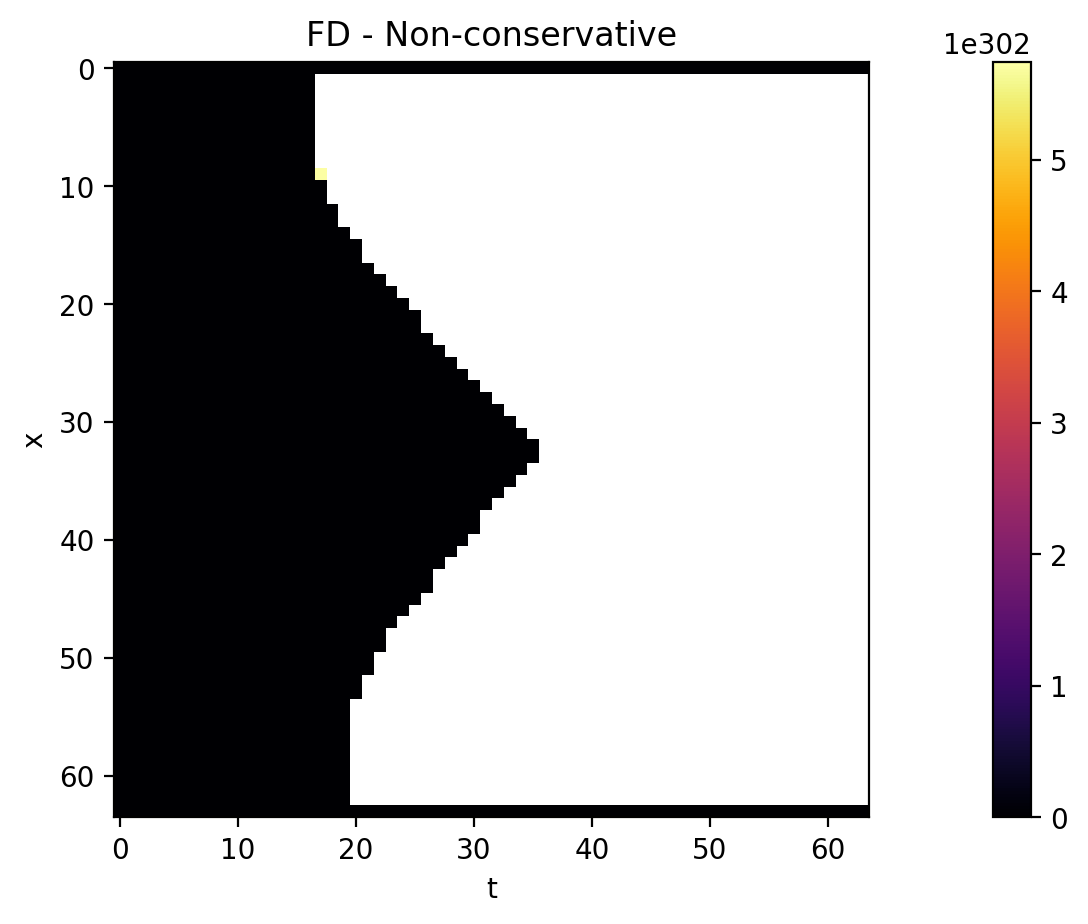

0.38126206398010254


/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/python_src/equations/burgers.py:50: RuntimeWarning: overflow encountered in power
  f = lambda u : np.power(u, 2) / 2
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/python_src/equations/burgers.py:54: RuntimeWarning: invalid value encountered in subtract
  b = ( 1 / (2 * dx)) * (f(u[i-1, 2:]) - f(u[i-1, 0:-2]))
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/python_src/equations/burgers.py:53: RuntimeWarning: invalid value encountered in subtract
  a  = (nu / dx**2) * (u[i-1, 2:] - 2 * u[i-1, 1:-1] + u[i-1, 0:-2])
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/python_src/equations/burgers.py:55: RuntimeWarning: invalid value encountered in subtract
  u[i, 1:-1] = u[i-1, 1:-1] + dt * (a - b)
/Users/vdesgrange/Development/Etudes/Thesis/closure-model/experiments/python_src/equations/burgers.py:53: RuntimeWarning: invalid value encountered in add
  a  = 

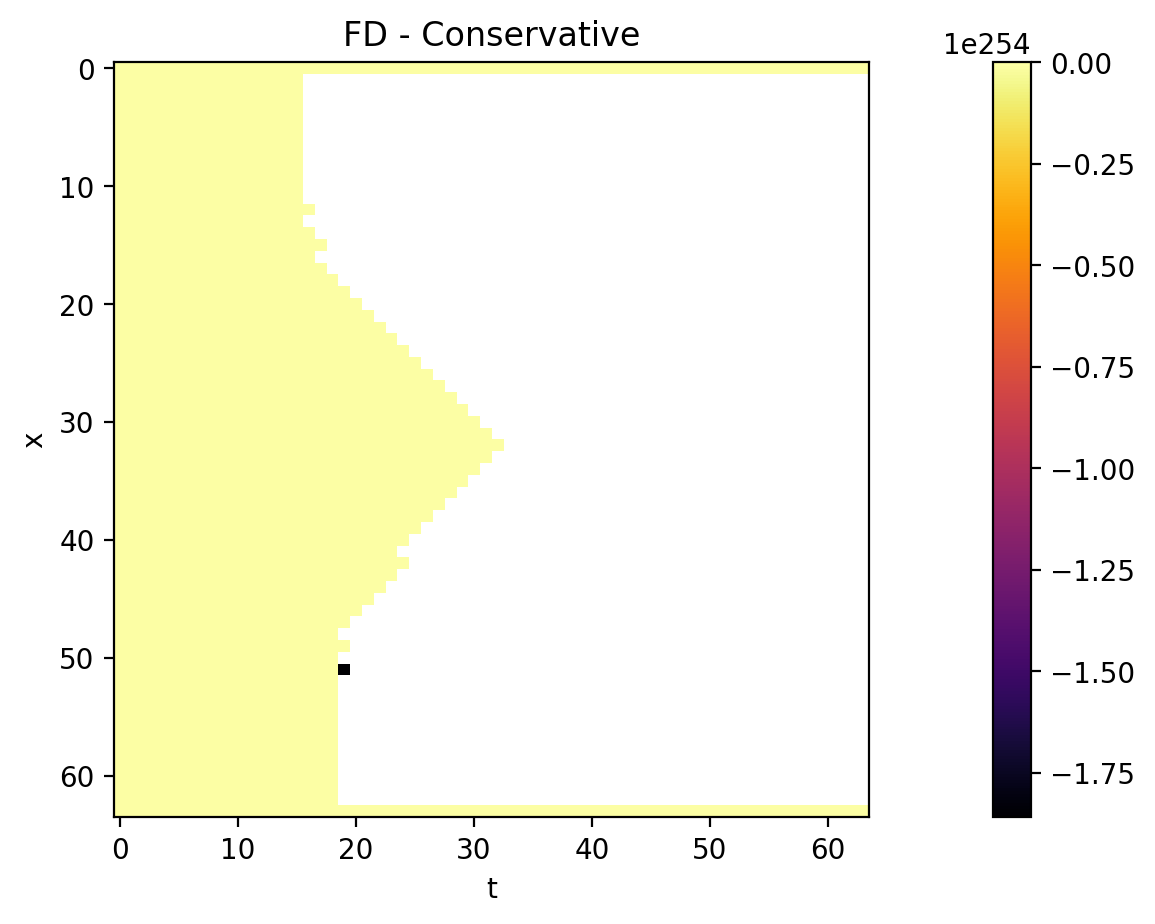

0.3542320728302002


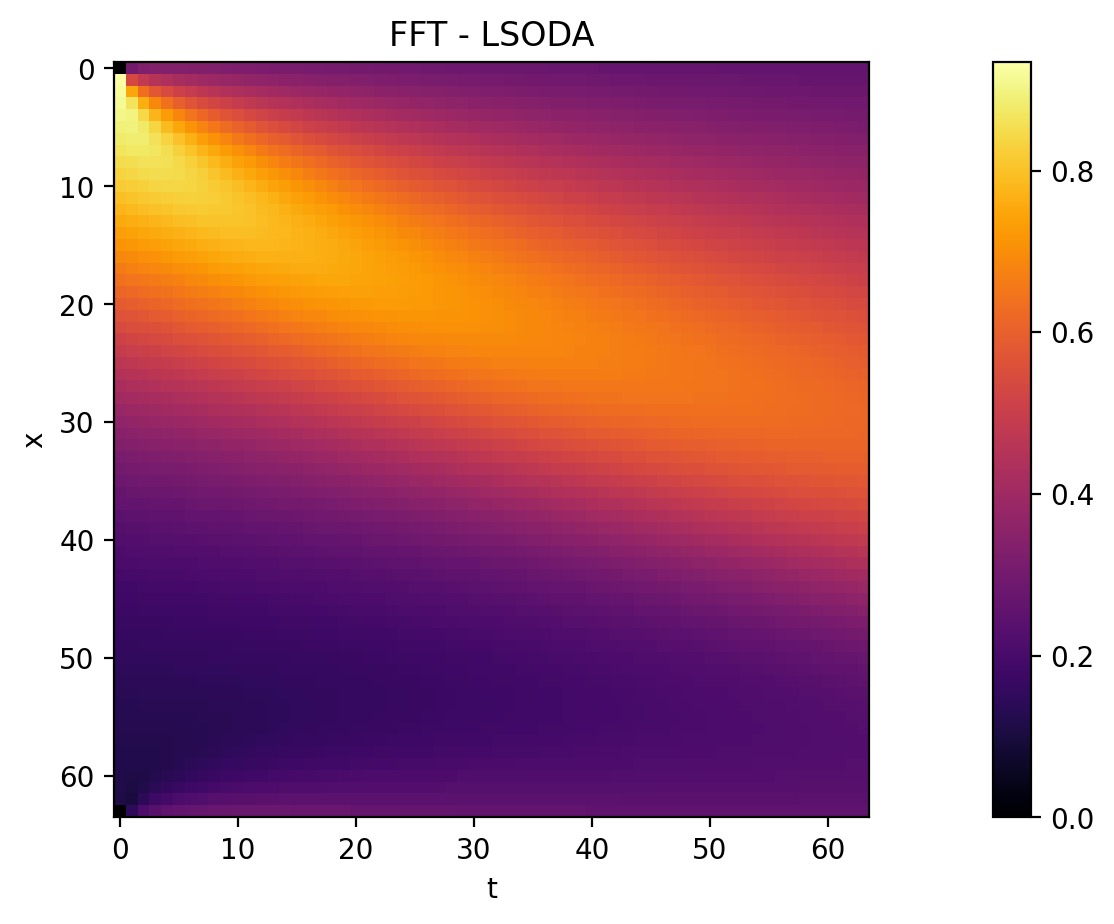

0.3761129379272461


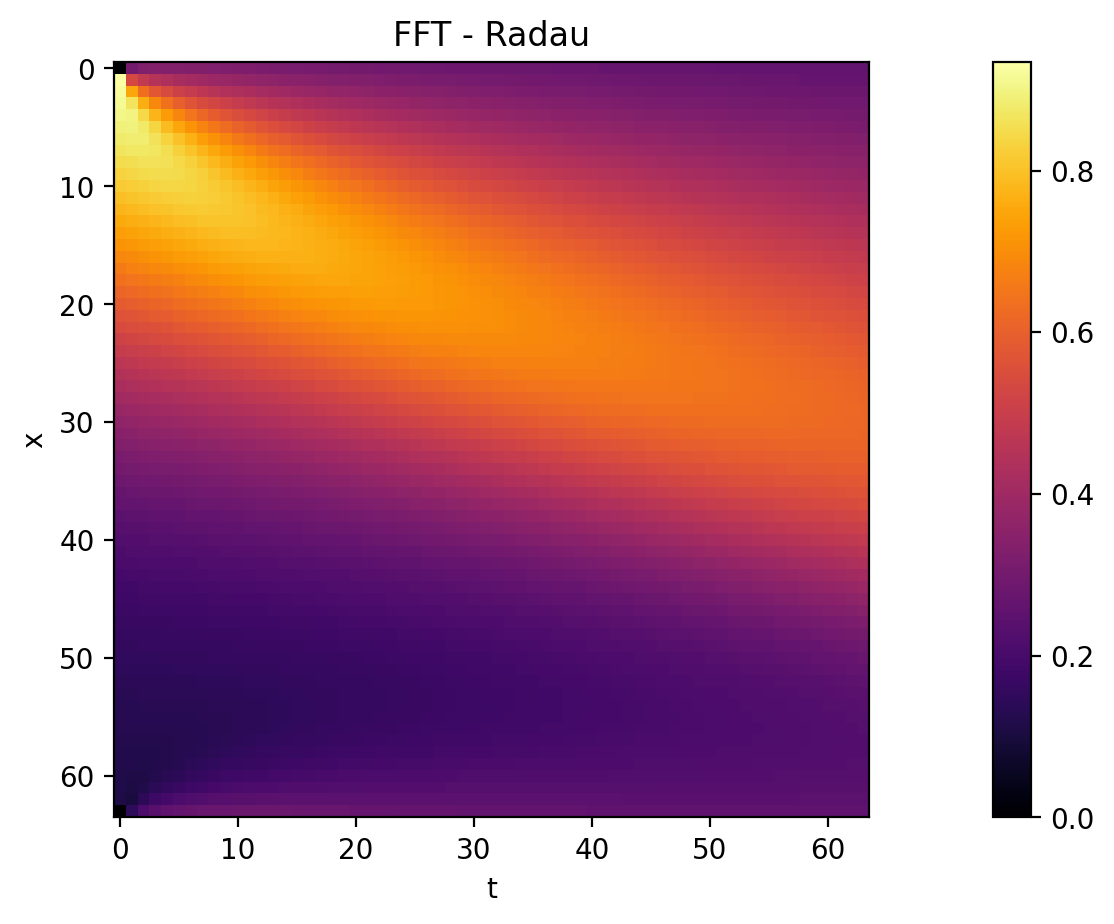

0.4454178810119629


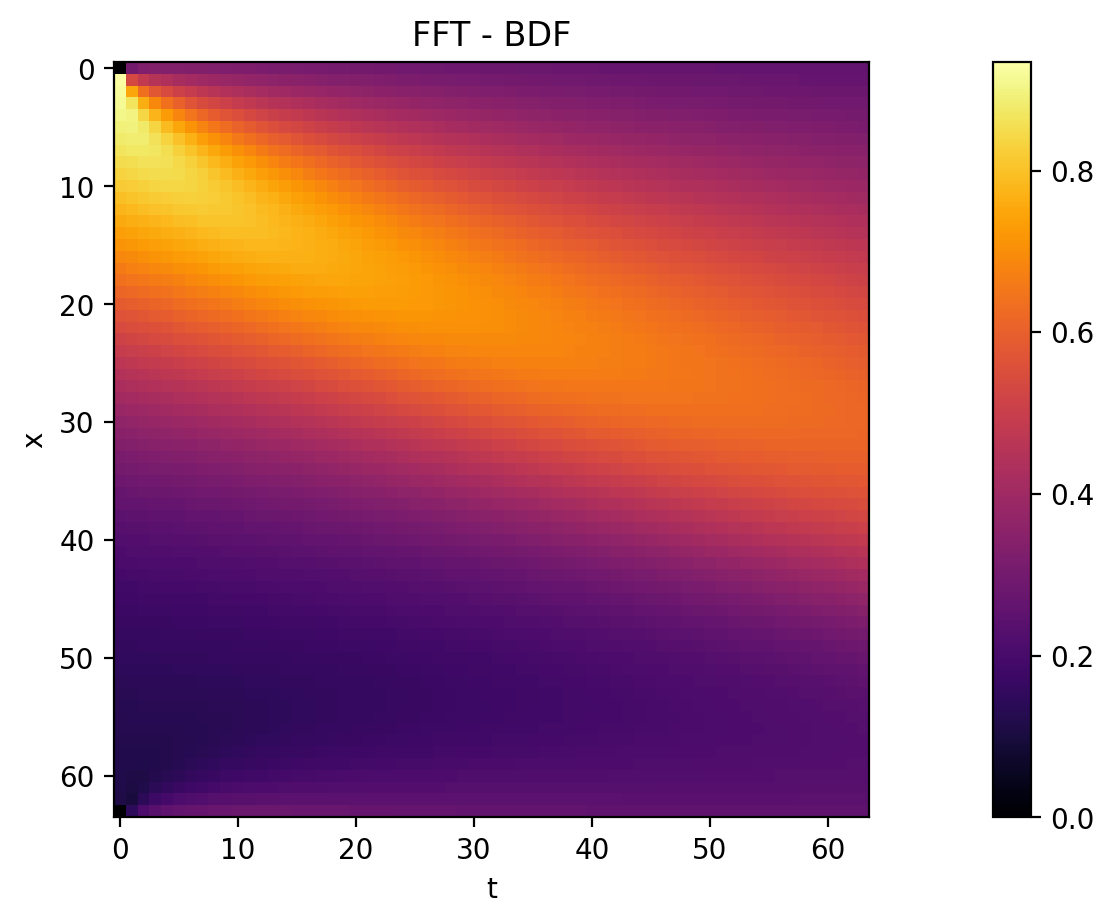

0.3552231788635254


ValueError: could not broadcast input array from shape (62) into shape (64)

In [4]:
# (Von Neumann analysis to do ?) Non-linear not possible
t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

u0 = burgers_analytical_init(t, x, nu)

start = time.time()
u_df = get_burgers_fd(dt, dx, t_n, nu, u0)
show_state(u_df.T, 'FD - Non-conservative', 't', 'x', None)
print(time.time() - start)

start = time.time()
u_cons = get_burgers_cons_fd(dt, dx, t_n, nu, u0)
show_state(u_cons.T, 'FD - Conservative', 't', 'x', None)
print(time.time() - start)

start = time.time()
u_fft = get_burgers_fft(t, dx, x_n, nu, u0, method="LSODA")
show_state(u_fft.T, 'FFT - LSODA', 't', 'x', None)
print(time.time() - start)

start = time.time()
u_fft = get_burgers_fft(t, dx, x_n, nu, u0, method="Radau")
show_state(u_fft.T, 'FFT - Radau', 't', 'x', None)
print(time.time() - start)

start = time.time()
u_rad = get_burgers_fft(t, dx, x_n, nu, u0, method="BDF")
show_state(u_rad.T, 'FFT - BDF', 't', 'x', None)
print(time.time() - start)

start = time.time()
u_nic = get_burgers_nicolson(dt, dx, t_n, x_n, nu, u0)
show_state(u_nic.T, 'Nicolson', 't', 'x', None)
print(time.time() - start)

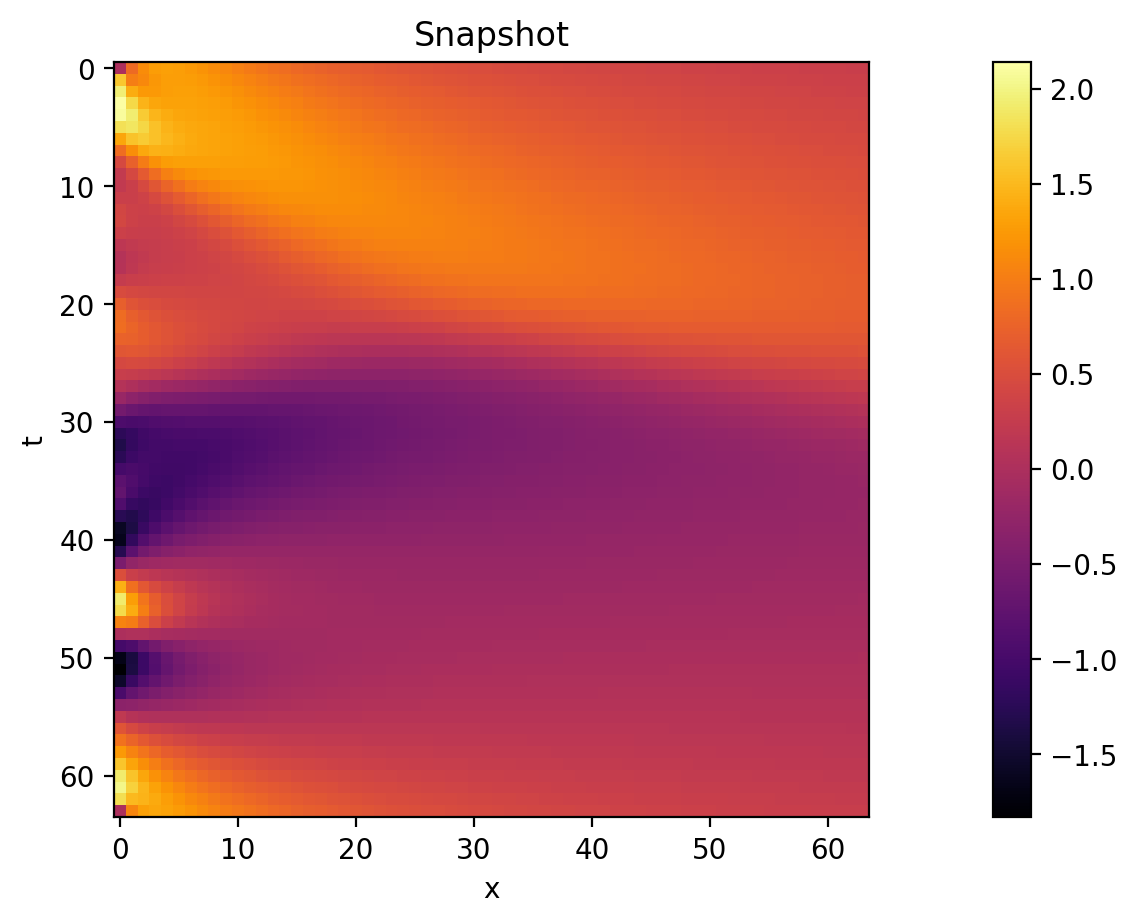

In [5]:
snap = burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, rand=-1, typ=1)
show_state(snap.T, "Snapshot")

---

## Operator F reconstruction

---

### Full-order model - Coarse grid

Several training datasets of high-dimension are generated, downsampled and compare to coarse grid solution as a point of comparison.

In [6]:
#training_set = generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 256, 1, './dataset/high_dim_random_burgers_training_set.pt')
training_set = read_dataset('dataset/high_dim_random_burgers_training_set.pt')

In [7]:
# def check_training_set(dataset):
#     for i in range(len(dataset)):
#         a, b, c, d = dataset[i]
#         show_state(b.T, i)

# check_training_set(training_set)

In [8]:
def coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, dataset):
    batch_size = len(dataset)
    
    t, dt = np.linspace(t_min, t_max, t_n, retstep=True)
    x, dx = np.linspace(x_min, x_max, x_n, retstep=True)

    rmse_tot = 0
    re_tot = 0
    for i in range(batch_size):
        # Get downsize solution
        t, u, _, _ = dataset[i]
        u = u.detach().numpy()
        
        # Generate coarse grid solution
        u0 = np.zeros((t_n, x_n))
        u0[0, :] = np.copy(u[0, :])
        pred_u = get_burgers_fft(t, dx, x_n, nu, u0, method="BDF")
        
        # Compute rmse and relative error
        re_tot += relative_err(u.T, pred_u.T)
        rmse_tot += rmse(pred_u.T, u.T)

    print(rmse_tot / batch_size)
    print(np.mean(re_tot) / batch_size)

coarse_reference(t_max, t_min, x_max, x_min, t_n, x_n, training_set)

0.1540448550337976
2.5839327387793714


### Model used by ODE solver

Let's define a few neural ODE model to use. First, with a basic linear one-layer model, efficient to work on linear PDE like Heat equation, but not for a non-linear PDE such as the Burgers equation.

In [9]:
class BurgersModelA(nn.Module):
    def __init__(self, n):
        super(BurgersModelA, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=n, out_features=int(n/2)),
            nn.Tanh(),
            nn.Linear(in_features=int(n/2), out_features=int(n/2)),
            nn.Tanh(),
            nn.Linear(in_features=int(n/2), out_features=int(n/2)),
            nn.Tanh(),
            nn.Linear(in_features=int(n/2), out_features=n),
            nn.Tanh()
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

In [17]:
n = x_n
f = nn.Sequential(
    nn.Linear(in_features=n, out_features=int(n/2)),
    nn.Tanh(),
    nn.Linear(in_features=int(n/2), out_features=int(n/2)),
    nn.Tanh(),
    nn.Linear(in_features=int(n/2), out_features=int(n/2)),
    nn.Tanh(),
    nn.Linear(in_features=int(n/2), out_features=n),
    nn.Tanh()
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = NeuralODE(f, sensitivity='adjoint', solver='tsit5', interpolator=None, atol=1e-5, rtol=1e-5, atol_adjoint=1e-5, rtol_adjoint=1e-5,).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [18]:
class BurgersModelB(nn.Module):
    def __init__(self, n):
        super(BurgersModelB, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 1, kernel_size=3, stride=1, bias=False),
            nn.ELU(),
            nn.Conv1d(1, 1, kernel_size=3, stride=1, bias=False),
            nn.ELU(),
            nn.ConvTranspose1d(1, 1, kernel_size=3, stride=1, bias=False),
            nn.ELU(),
            nn.ConvTranspose1d(1, 1, kernel_size=3, stride=1, bias=False),
            nn.Sigmoid()
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

### Training - continuous residual

In [19]:
loss_fn = mse_fn

In [24]:
def training_ode_solver_net(net, epochs, t_n, x_n, dataset, val_epoch=10, rands=[], downsize=0):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    
    tr_dataset, val_dataset = process_dataset(dataset)
    training_batch_size = len(tr_dataset)
    training_set_idx = np.arange(0, training_batch_size)
    val_batch_size = len(val_dataset)
    val_set_idx = np.arange(0, val_batch_size)

    # Epoch
    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        np.random.shuffle(training_set_idx)
        
        # === Train ===
        net.train()
        
        for i in training_set_idx:
            # === Randomness ====
            rand = -1
            if (i < len(rands)):
                rand = rands[i]
            
            tr_t, tr_bu, _, _ = tr_dataset[i]
            tr_b0 = tr_bu[0, :]
            
            # pred_u = odeint(net, tr_b0, tr_t)
            tr_t_eval, pred_u = net(tr_b0, tr_t)
            loss = loss_fn(pred_u.T, tr_bu.T)
            loss += 0.01 * sum([torch.sum(p.pow(2.)) for p in net.parameters()])
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True) # retain_graph=True if 2+ losses
            optimizer.step()
            optimizer.zero_grad()
        
        print('Epoch %d loss %f'%(e, float(loss_tot / float(training_batch_size))))
        
        
        # === Evaluate ===
        if (e > val_epoch):
            net.eval()
            with torch.no_grad():
                np.random.shuffle(val_set_idx)
                
                for j in val_set_idx:
                    val_t, val_bu, _, _ = dataset[j]
                    val_b0 = val_bu[0, :]

                    # val_pred_u = odeint(net, val_b0, val_t)
                    val_t_eval, val_pred_u = net(val_b0, val_t)
                    val_loss = loss_fn(val_pred_u.T, val_bu.T)
                    loss += 0.01 * sum([torch.sum(p.pow(2.)) for p in net.parameters()])
                    
                    val_loss_tot += val_loss.item()
                print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(training_batch_size))))

        if e % 10 == 0:
            sample_t, sample_b0, sample_real = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, rand, 1)
            sample_b0 = sample_real[0, :]
            sample_t_eval, sample_pred = net(sample_b0, sample_t)
            show_state(sample_real.T, 'Real', 't', 'x', None)
            show_state(sample_pred.detach().numpy().T, 'Determined', 't', 'x', None)
            # sample_pred = odeint(net, sample_b0, sample_t)
            # sample_pred = odeint(net, sample_b0, torch.from_numpy(np.linspace(0,5,640)).float())
    
    return net

### Training

Epoch 1 loss 1.094485
Epoch 2 loss 0.673145
Epoch 3 loss 0.597104
Epoch 4 loss 0.584479
Epoch 5 loss 0.582538
Epoch 6 loss 0.582255
Epoch 6 validation loss 0.614901
Epoch 7 loss 0.582147
Epoch 7 validation loss 0.615014
Epoch 8 loss 0.582219
Epoch 8 validation loss 0.614971
Epoch 9 loss 0.582241
Epoch 9 validation loss 0.614963
Epoch 10 loss 0.582244
Epoch 10 validation loss 0.614965


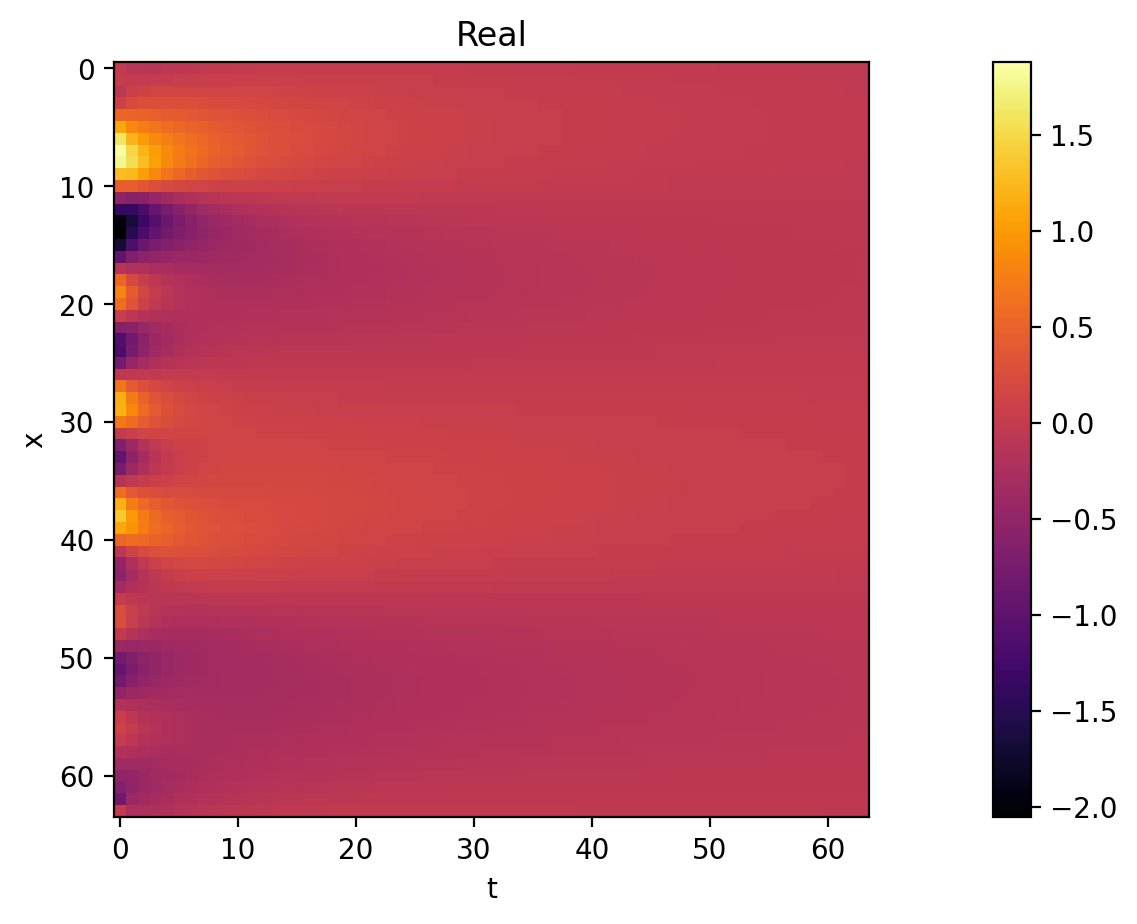

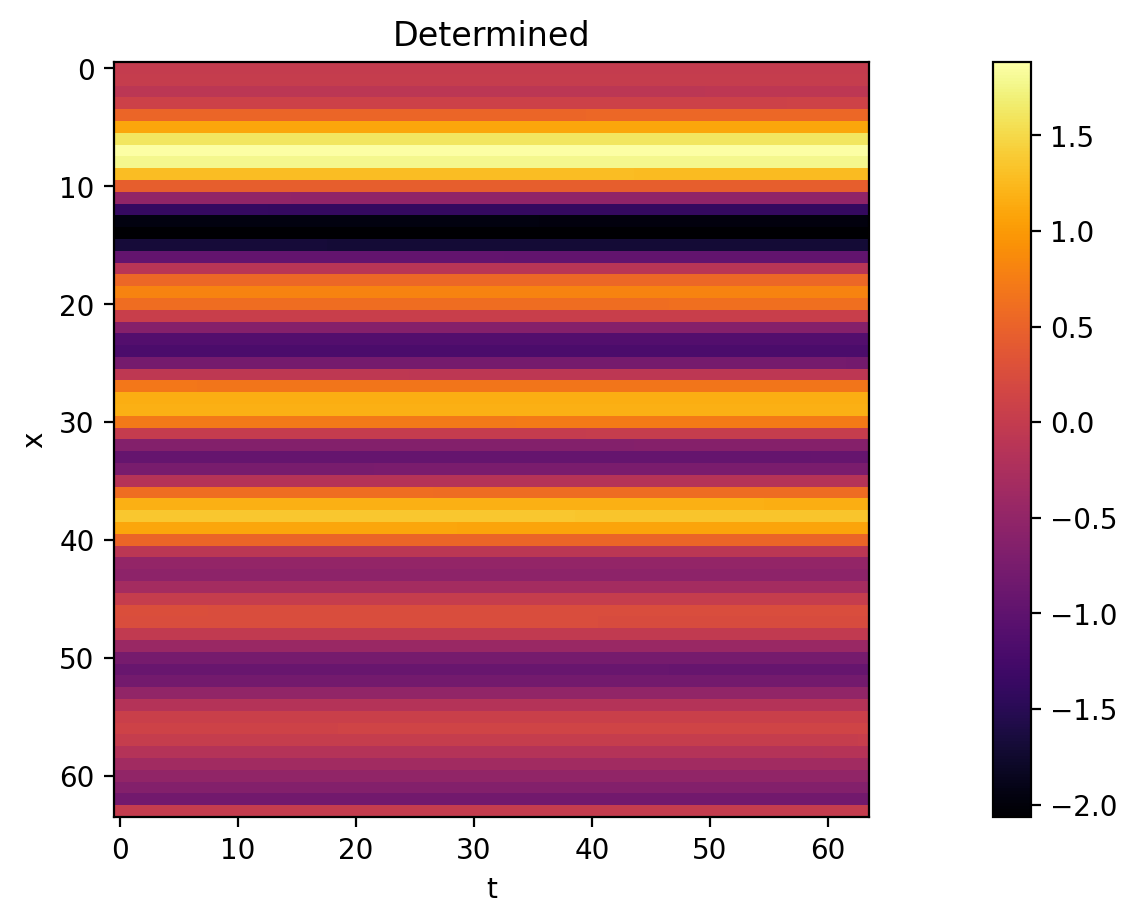

In [25]:
%matplotlib inline

# Experiment 1 - Linear operator, nu=0.003, epoch=2
# net = BurgersModelA(x_n)
F = training_ode_solver_net(net, 10, t_n, x_n, training_set[:32], 5, [], -1)

### Training - Discrete residual

In [ ]:
def training_discrete_residual_net(net, epochs, t_n, x_n, dataset, val_epoch=10, rands=[], downsize=0):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    training_batch_size = len(dataset)
    training_set_idx = np.arange(0, training_batch_size)
    
    tr_min_t = 1
    tr_max_t = int(len(dataset[0][0]) / 5 * 3)
    val_max_t = int(tr_max_t + len(dataset[0][0]) / 5 * 2)
    
    for e in range(1, epochs + 1):
        loss_tot = 0
        val_loss_tot = 0
        np.random.shuffle(training_set_idx)
        
        # === Train ===
        net.train()
        for i in training_set_idx:
            # === Randomness ====
            rand = -1
            if (i < len(rands)):
                rand = rands[i]
            
            optimizer.zero_grad()
            
            t, bu, _, _ = dataset[i]
            tr_t =  t[tr_min_t:tr_max_t]
            tr_b0 = bu[tr_min_t, :]
            tr_bu = bu[tr_min_t:tr_max_t, :]
            
            pred_u = np.zeros(tr_bu.shape)
            pred_u[0, :] = np.copy(tr_b0)
            for i in range(1, tr_bu.shape[0]):
                tmp = net(t[i], torch.from_numpy(pred_u[i-1, :]).float())
                pred_u[i, :] = tmp.clone().detach().numpy()
                loss = loss_fn(tmp.T, tr_bu[i].T)
                loss_tot += loss.item()
            
            loss.backward(retain_graph=False) # retain_graph=True if 2+ losses
            optimizer.step()
        
        print('Epoch %d loss %f'%(e, float(loss_tot / float(training_batch_size))))
        
        # === Evaluate ===
        net.eval()
        if (e > val_epoch):
            for j in training_set_idx:
                t, bu, _, _ = dataset[j]
                val_t = t[tr_max_t:val_max_t]
                val_b0 = bu[tr_max_t, :]
                val_bu = bu[tr_max_t:val_max_t, :]
                
                val_pred_u = odeint(net, val_b0, val_t)
                val_loss = loss_fn(val_pred_u.T, val_bu.T)
                val_loss_tot += val_loss.item()
            print('Epoch %d validation loss %f'%(e, float(val_loss_tot / float(training_batch_size))))
        
        if e % 10 == 0:
            sample_t, sample_b0, sample_real = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, rand, -1)
            sample_b0 = sample_real[1, :]
            # sample_pred = odeint(net, sample_b0, sample_t[1:])
            sample_pred = odeint(net, sample_b0, torch.from_numpy(np.linspace(0,5,640)).float())
            show_state(sample_real[1:].T, 'Real', 't', 'x', None)
            show_state(sample_pred.detach().numpy().T, 'Determined', 't', 'x', None)
    
    return net

In [ ]:
net2 = BurgersModelB(x_n)
F2 = training_discrete_residual_net(net2, 10, t_n, x_n, training_set[0:32], 5, [], -1)

## Visualization

Let's train this basic NN and visualize its efficiency to match the solution u(t,x)

In [ ]:
def check_efficiency(net, n_sim=10, debug=False):
    rmse_tot = 0
    
    for i in range(n_sim):
        t, b0, bu = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, -1, -1)
        pred_u = odeint(net, b0, t).detach().numpy()
        u = bu.detach().numpy()
        rmse_tot += rmse(pred_u.T, u.T)

        if debug:
            print("RMSE = ", rmse(pred_u.T, u.T))
            show_err(np.abs(pred_u.T - u.T), 'Error NN vs. Real', 't', 'x', None)
            show_state(u.T, 'Real', 't', 'x', None)
            show_state(pred_u.T, 'Expected', 't', 'x', None)
            
    return rmse_tot / n_sim

In [ ]:
check_weights(F)

In [ ]:
print(check_efficiency(F, 1, True))

In [ ]:
def training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, nu=0.003, batch_size=10):
    optimizer = optim.RMSprop(net.parameters(), lr=0.003)

    for e in range(1, epochs + 1):
        print("Epoch ", e)
        loss_tot = 0
        val_loss_tot = 0
        
        net.train()
        for i in range(batch_size):
            print("Batch ", i)
            optimizer.zero_grad()
            t, b0, bu = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, -1, 0)
            pred_u = odeint(net, b0[1:-1], t)
            loss = loss_fn(pred_u, bu[:, 1:-1])
            loss_tot += loss.item()
            
            loss.backward(retain_graph=True)
            optimizer.step()

        if e % 1 == 0:
            t, b0, bu = get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, -1, 0)
            visualize_u_from_F(net, t, bu[:,1:-1], b0[1:-1])
            
            print('Epoch %d loss %f'%(e, float(loss_tot / float(batch_size))))
    
    return net